## P7 - Prep the data 

---

In [2]:
import random
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from rich.pretty import pprint

%load_ext rich

import warnings

warnings.filterwarnings("ignore")


---

## Kernel Kaggle

In [3]:
# Fonction Cleaning Finale
def cleaning(features, test_features, encoding="ohe"):
    """Fonction cleaning finale"""
    # Extract the ids
    train_ids = features["SK_ID_CURR"]
    test_ids = test_features["SK_ID_CURR"]

    # Extract the labels for training
    labels = features["TARGET"]

    # Remove the ids and target
    features = features.drop(columns=["SK_ID_CURR", "TARGET"])
    test_features = test_features.drop(columns=["SK_ID_CURR"])

    # One Hot Encoding
    if encoding == "ohe":
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join="inner", axis=1)

        # No categorical indices to record
        cat_indices = "auto"

    # Integer label encoding
    elif encoding == "le":
        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == "object":
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(
                    np.array(features[col].astype(str)).reshape((-1,))
                )
                test_features[col] = label_encoder.transform(
                    np.array(test_features[col].astype(str)).reshape((-1,))
                )

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print("Training Data Shape: ", features.shape)
    print("Testing Data Shape: ", test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Impute the domainnomial features
    imputer = SimpleImputer(strategy="median")

    features = imputer.fit_transform(features)
    test_features = imputer.transform(test_features)

    # Scale the domainnomial features
    scaler = MinMaxScaler(feature_range=(0, 1))

    features = scaler.fit_transform(features)
    test_features = scaler.transform(test_features)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    return feature_names, labels, features, test_features, train_ids, test_ids


In [4]:
# Training data
app_train = pd.read_csv("../../data/raw/application_train.csv")
print("Training data shape: ", app_train.shape)
app_train.head(2)

# Testing data features
app_test = pd.read_csv("../../data/raw/application_test.csv")
print("Testing data shape: ", app_test.shape)
app_test.head(2)

# copy to add fe
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

# feature engineering with domain knowledge variables
app_train_domain["CREDIT_INCOME_PERCENT"] = (
    app_train_domain["AMT_CREDIT"] / app_train_domain["AMT_INCOME_TOTAL"]
)
app_train_domain["ANNUITY_INCOME_PERCENT"] = (
    app_train_domain["AMT_ANNUITY"] / app_train_domain["AMT_INCOME_TOTAL"]
)
app_train_domain["CREDIT_TERM"] = (
    app_train_domain["AMT_ANNUITY"] / app_train_domain["AMT_CREDIT"]
)
app_train_domain["DAYS_EMPLOYED_PERCENT"] = (
    app_train_domain["DAYS_EMPLOYED"] / app_train_domain["DAYS_BIRTH"]
)

app_test_domain["CREDIT_INCOME_PERCENT"] = (
    app_test_domain["AMT_CREDIT"] / app_test_domain["AMT_INCOME_TOTAL"]
)
app_test_domain["ANNUITY_INCOME_PERCENT"] = (
    app_test_domain["AMT_ANNUITY"] / app_test_domain["AMT_INCOME_TOTAL"]
)
app_test_domain["CREDIT_TERM"] = (
    app_test_domain["AMT_ANNUITY"] / app_test_domain["AMT_CREDIT"]
)
app_test_domain["DAYS_EMPLOYED_PERCENT"] = (
    app_test_domain["DAYS_EMPLOYED"] / app_test_domain["DAYS_BIRTH"]
)

# Create an anomalous flag column
app_train_domain["DAYS_EMPLOYED_ANOM"] = app_train_domain["DAYS_EMPLOYED"] == 365243
# Replace the anomalous values with nan
app_train_domain["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

app_test_domain["DAYS_EMPLOYED_ANOM"] = app_test_domain["DAYS_EMPLOYED"] == 365243
app_test_domain["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)


app_train_domain["DAYS_EMPLOYED_ANOM"] = app_train_domain["DAYS_EMPLOYED_ANOM"].astype(
    "int32"
)
app_test_domain["DAYS_EMPLOYED_ANOM"] = app_test_domain["DAYS_EMPLOYED_ANOM"].astype(
    "int32"
)

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [5]:
liste_features, y_train, X_train, X_test, train_ids, test_ids = cleaning(
    app_train_domain, app_test_domain, encoding="ohe"
)
train_final = pd.DataFrame(X_train, columns=liste_features)
train_final["LABELS"] = y_train
train_final["SK_ID_CURR"] = train_ids

test_final = pd.DataFrame(X_test, columns=liste_features)
test_final["SK_ID_CURR"] = test_ids


Training Data Shape:  (307511, 246)
Testing Data Shape:  (48744, 246)


We create a test and train set from the train and test set we obtain.  

We don't have true label for the test set, thus we will use the train set to train and evaluate our models.  
To do so, we split it into train and test.  
We will create **X_train_split**, **y_train_split**, **X_val** and **y_val**

In [6]:
from sklearn.model_selection import train_test_split

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

---

## Models

### SMOTE

In [8]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_train_split_resampled, y_train_split_resampled = smote.fit_resample(
    X_train_split, y_train_split
)

# Check the new class distribution
print("Original class distribution:", pd.Series(y_train).value_counts())
print(
    "Resampled class distribution:", pd.Series(y_train_split_resampled).value_counts()
)

Original class distribution: TARGET
0    282686
1     24825
Name: count, dtype: int64
Resampled class distribution: TARGET
0    189324
1    189324
Name: count, dtype: int64


---

---

In [60]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import (
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
    make_scorer,
    fbeta_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# Model class
class Model:
    def __init__(self, name, estimator, params):
        """
        Parameters:
        - name: str, name of the model
        - estimator: sklearn estimator object
        - params: dict, parameters for grid search
        """

        self.name = name
        self.estimator = estimator
        self.params = params
        self.best_model = None

        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_pred = None
        self.y_pred_binary = None

        self.results = None
        self.best_threshold = None
        self.min_cost = None

    def load_data(self, X_train, X_test, y_train, y_test):
        """Load training and testing data."""
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def find_best_params(self, cv=5, beta=10, search_type="grid", use_smote=False):
        """
        2 methods: GridSearchCV or RandomizedSearchCV
        Possibility to use oversampling with SMOTE in an integrated pipeline to avoid data leakage
        """
        self.beta = beta

        if self.X_train is None or self.y_train is None:
            raise ValueError("Data not loaded yet. Call load_data first.")

        # The best parameters will maximize the fbeta_scorer
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)

        # simple pipeline
        steps = []
        if use_smote:
            steps.append(("smote", SMOTE()))  # Add SMOTE if use_smote is True
        steps.append(("estimator", self.estimator))

        # Create the pipeline
        pipeline = Pipeline(steps)

        if search_type == "grid_search":
            param_grid = {
                f"estimator__{param}": config["values"]
                for param, config in self.params.items()
            }

            search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                cv=cv,
                scoring=fbeta_scorer,
                n_jobs=6,
            )

        elif search_type == "random_search":
            param_distributions = {}
            for param, config in self.params.items():
                if config["type"] == "int":
                    param_distributions[f"estimator__{param}"] = randint(
                        config["min"], config["max"] + 1
                    )
                elif config["type"] == "float":
                    param_distributions[f"estimator__{param}"] = uniform(
                        config["min"], config["max"] - config["min"]
                    )
                elif config["type"] == "str":
                    param_distributions[f"estimator__{param}"] = config["values"]

            search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_distributions,
                cv=cv,
                scoring=fbeta_scorer,
                n_iter=100,  # Randomized search is 'always' better than grid search if n_iter is > 90
                n_jobs=-4,
            )

        else:
            raise ValueError(
                "search_type must be 'grid_search' or 'random_search' for GridSearchCV or RandomizedSearchCV"
            )

        search.fit(self.X_train, self.y_train)
        self.best_model = search.best_estimator_.steps[0][1]

        return {
            "best_params": search.best_params_,
            "best_score (fβ)": search.best_score_,
        }

    def find_optimal_threshold_for_min_cost(self, cost_fn=10, cost_fp=1):
        """
        Minize the total cost given the simple formula.
        Find the best threshold given the minimized total cost
        :param desired_fnr: targeted False Negative Rate (FNR).
        """
        # Get predictions as probabilities
        y_pred = self.best_model.predict_proba(self.X_test)

        self.y_pred = y_pred

        thresholds = np.linspace(0, 1, 1000)
        min_cost = float("inf")
        best_threshold = 0.5

        for threshold in thresholds:
            y_pred_binary = (self.y_pred[:, 1] >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(self.y_test, y_pred_binary).ravel()

            # Simple cost function that directly depends on the costs ratios to determine the importance of FP or FN.
            # In our case, a False Negative cost much ore that a False positive.
            total_cost = (fp * cost_fp) + (fn * cost_fn)

            if total_cost < min_cost:
                min_cost = total_cost
                best_threshold = threshold
                best_y_pred_binary = y_pred_binary

        y_pred_binary = (self.y_pred[:, 1] >= best_threshold).astype(int)

        self.y_pred_binary = best_y_pred_binary
        self.best_threshold = best_threshold
        self.min_cost = min_cost

        print(f"best_threshold: {best_threshold:.4f}, minimized cost: {min_cost:.4f}")

    def evaluate(self, metrics=None):
        """
        Evaluate the best model on the test set using multiple metrics.
        Parameters: metrics : List of metric names to calculate'
        Returns: Dictionary containing the scores for all requested metrics
        """
        if self.best_model is None:
            raise ValueError("Model not trained yet. Call find_best_params first.")

        results = {}

        if metrics is None:
            metrics = ["fbeta", "precision", "recall", "roc_auc"]

        # Calculate requested metrics
        for metric in metrics:
            if metric == "fbeta":
                results["fbeta"] = fbeta_score(
                    self.y_test, self.y_pred_binary, beta=self.beta
                )
            elif metric == "precision":
                results["precision"] = precision_score(self.y_test, self.y_pred_binary)
            elif metric == "recall":
                results["recall"] = recall_score(self.y_test, self.y_pred_binary)
            elif metric == "roc_auc":
                results["roc_auc"] = roc_auc_score(self.y_test, self.y_pred_binary)

        print(f"(β={self.beta}) score: {results}")

        self.results = results

    def get_model_info(self):
        """
        Returns a dictionary containing the model's information.
        """
        return {
            "name": self.name,
            "estimator": self.estimator,
            "params": self.params,
            "best_model": self.best_model,
            "X_train": self.X_train,
            "X_test": self.X_test,
            "y_train": self.y_train,
            "results": self.results,
            "min_cost": self.min_cost,
            "best_threshold": self.best_threshold,
        }


5 steps :  
1. load data with **.load_data**   
2. find best params with GridSearchCV using **.find_best_params**  
3. get the minimized cost for the best_model and the corresponding classification threshold with **.find_optimal_threshold_for_min_cost**  
4. evaluate on test set with **.evaluate**  
5. Retreive the info for each model wth the **.get_model_info** (usefull to log into mlflow)  


In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [61]:
dummy_model = Model(
    name="Dummy Classifier",
    estimator=DummyClassifier(random_state=42),
    params={
        "strategy": {
            "type": "str",
            "values": ["most_frequent", "stratified", "uniform"],
        }
    },
)

logistic_model = Model(
    name="Logistic Regression",
    estimator=LogisticRegression(random_state=42, verbose=1, n_jobs=1),
    params={
        "C": {"type": "float", "values": np.logspace(0, 1, num=10).tolist()},
        "tol": {"type": "int", "values": [0.001, 0.01]},
    },
)

random_forest = Model(
    name="Random_forest_classifier",
    estimator=RandomForestClassifier(random_state=42, verbose=1, n_jobs=1),
    params={
        "n_estimators": {
            "type": "int",
            "min": 100,
            "max": 200,
            "values": [100, 200],
        },
        "min_samples_split": {
            "type": "int",
            "min": 2,
            "max": 5,
            "values": [2, 3, 5],
        },
        "min_samples_leaf": {
            "type": "int",
            "min": 1,
            "max": 3,
            "values": [1, 2, 3],
        },
    },
)

lgbm_model = Model(
    name="LightGBM Classifier",
    estimator=LGBMClassifier(random_state=42, n_jobs=1, verbose=-1),
    params={
        "learning_rate": {
            "type": "float",
            "values": [0.01, 0.05, 0.1],
            "min": 0.01,
            "max": 0.1,
        },
        "n_estimators": {"type": "int", "values": [100, 200], "min": 100, "max": 200},
        "max_depth": {"type": "int", "values": [3, 5, 7], "min": 3, "max": 7},
    },
)
# n_jobs are set to 1 to avoid nested parallelization between the model's n_job and the grid_search one.
# Parallelization is done at the gridsearch level.

In [26]:
dummy_model_smote = Model(
    name="Dummy Classifier",
    estimator=DummyClassifier(random_state=42),
    params={
        "strategy": {
            "type": "str",
            "values": ["most_frequent", "stratified", "uniform"],
        }
    },
)

logistic_model_smote = Model(
    name="Logistic Regression",
    estimator=LogisticRegression(random_state=42, verbose=1, n_jobs=1),
    params={
        "C": {"type": "float", "values": np.logspace(0, 1, num=10).tolist()},
        "tol": {"type": "int", "values": [0.001, 0.01]},
    },
)

lgbm_model_smote = Model(
    name="LightGBM Classifier",
    estimator=LGBMClassifier(random_state=42, n_jobs=1, verbose=-1),
    params={
        "learning_rate": {
            "type": "float",
            "values": [0.01, 0.05, 0.1],
            "min": 0.01,
            "max": 0.1,
        },
        "n_estimators": {"type": "int", "values": [100, 200], "min": 100, "max": 200},
        "max_depth": {"type": "int", "values": [3, 5, 7], "min": 3, "max": 7},
    },
)


In [ ]:
def process_model(
    model_name, beta=10, search_type="grid_search", cost_fn=10, cost_fp=1
):
    """All the steps to do to run the different functions of the class Model, and to get the results"""

    # 1. Load the data
    model_name.load_data(X_train_split, X_val, y_train_split, y_val)

    # 2. Find best parameters
    best_params = model_name.find_best_params(beta=beta, search_type=search_type)
    pprint(best_params)
    print(f"{model_name.name}:")

    # 3. Min cost and optimal threshold
    model_name.find_optimal_threshold_for_min_cost(cost_fn=cost_fn, cost_fp=cost_fp)

    # 4. Evaluate the model
    model_name.evaluate()


In [63]:
dummy_model.best_model

DummyClassifier(random_state=42, strategy='uniform')

In [ ]:
# 1. Load the data
dummy_model.load_data(X_train_split, X_val, y_train_split, y_val)

# 2. Find best parameters
print(f"{dummy_model.name}:")
pprint(dummy_model.find_best_params(beta=10, search_type="random_search"))

# 3. min cost and optimal threshold
dummy_model.find_optimal_threshold_for_min_cost(cost_fn=10, cost_fp=1)

# 4. evalutate the model
dummy_model.evaluate()

{
│   'best_params': {'estimator__strategy': 'uniform'},
│   'best_score (fβ)': np.float64(0.47609782575933635)
}
Dummy Classifier:
best_threshold: 0.5005, minimized cost: 49490.0000
(β=10) score: {'fbeta': 0.0, 'precision': 0.0, 'recall': 0.0, 'roc_auc': np.float64(0.5)}


In [16]:
# 1. Load the data
logistic_model_smote.load_data(X_train_split, X_val, y_train_split, y_val)

# 2. Find best parameters
print(f"{logistic_model_smote.name}:")
pprint(
    logistic_model_smote.find_best_params2(
        beta=10, search_type="grid_search", use_smote=True
    )
)

# 3. min cost and optimal threshold
logistic_model_smote.find_optimal_threshold_for_min_cost(cost_fn=10, cost_fp=1)

# 4. evalutate the model
logistic_model_smote.evaluate()

Logistic Regression:
{
│   'best_params': {
│   │   'estimator__C': 2.154434690031884,
│   │   'estimator__tol': 0.001
│   },
│   'best_score (fβ)': np.float64(0.6262274671202629)
}
best_threshold: 0.5455, minimized cost: 34430.0000
(β=10) score: {'fbeta': 0.5786485040440215, 'precision': 0.17044266294876265, 'recall': 0.5928470398060214, 'roc_auc': np.float64(0.6701725031756351)}


In [29]:
dummy_model.name

'Dummy Classifier'

In [ ]:
importance = model.feature_importance(importance_type=importance_type)
feature_importance = pd.DataFrame(
    {"feature": feature_names, "importance": importance}
).sort_values(by="importance", ascending=False)

In [69]:
# 1. Load the data
logistic_model.load_data(X_train_split, X_val, y_train_split, y_val)

# 2. Find best parameters
print(f"{logistic_model.name}:")
pprint(logistic_model.find_best_params(beta=10, search_type="grid_search"))

# 3. min cost and optimal threshold
logistic_model.find_optimal_threshold_for_min_cost(cost_fn=10, cost_fp=1)

# 4. evalutate the model
logistic_model.evaluate()

Logistic Regression:
{
│   'best_params': {'C': 4.641588833612778, 'tol': 0.001},
│   'best_score': np.float64(0.01016076607046979)
}
best_threshold: 0.1041, minimized cost: 33925.0000
(β=10) score: {'fbeta': 0.5480332940338708, 'precision': 0.1861247560729426, 'recall': 0.5589007880379875, 'roc_auc': np.float64(0.6725171974281249)}


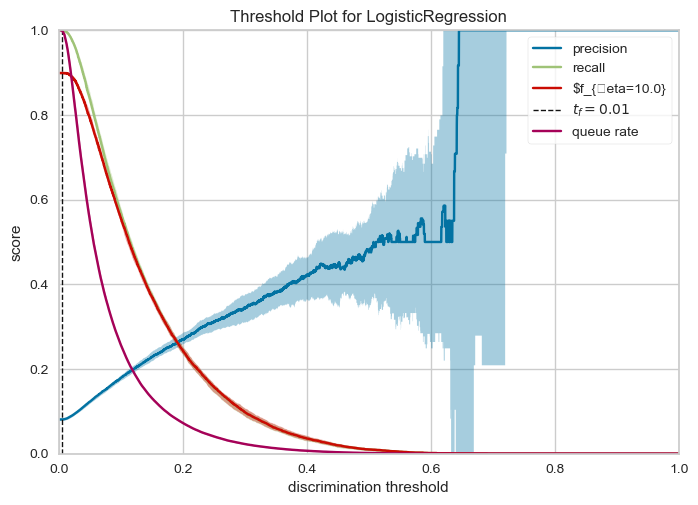

<Axes: title={'center': 'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(
    logistic_model.best_model, fbeta=logistic_model.beta
)

visualizer.fit(logistic_model.X_train, logistic_model.y_train)
visualizer.show()

In [24]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

# 1. Load the data
lgbm_model_smote.load_data(X_train_split, X_val, y_train_split, y_val)

# 2. Find best parameters
print(f"{lgbm_model_smote.name}:")
pprint(
    lgbm_model_smote.find_best_params2(
        beta=10, search_type="grid_search", use_smote=False
    )
)

# 3. min cost and optimal threshold
lgbm_model_smote.find_optimal_threshold_for_min_cost(cost_fn=10, cost_fp=1)

# 4. evalutate the model
lgbm_model_smote.evaluate()

LightGBM Classifier:


/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklea

{
│   'best_params': {
│   │   'estimator__learning_rate': 0.01,
│   │   'estimator__max_depth': 3,
│   │   'estimator__n_estimators': 100
│   },
│   'best_score (fβ)': np.float64(0.35588056339156415)
}
best_threshold: 0.4264, minimized cost: 40701.0000
(β=10) score: {'fbeta': 0.6557765042979943, 'precision': 0.11884615384615385, 'recall': 0.6868054152354011, 'roc_auc': np.float64(0.6205979546382473)}


In [27]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

# 1. Load the data
lgbm_model_smote.load_data(X_train_split, X_val, y_train_split, y_val)

# 2. Find best parameters
print(f"{lgbm_model_smote.name}:")
pprint(
    lgbm_model_smote.find_best_params2(
        beta=10, search_type="random_search", use_smote=False
    )
)

# 3. min cost and optimal threshold
lgbm_model_smote.find_optimal_threshold_for_min_cost(cost_fn=10, cost_fp=1)

# 4. evalutate the model
lgbm_model_smote.evaluate()

LightGBM Classifier:


/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklea

{
│   'best_params': {
│   │   'estimator__learning_rate': np.float64(0.09333481050857016),
│   │   'estimator__max_depth': 7,
│   │   'estimator__n_estimators': 195
│   },
│   'best_score (fβ)': np.float64(0.024786379827821222)
}
best_threshold: 0.0901, minimized cost: 31851.0000
(β=10) score: {'fbeta': 0.6304985852278271, 'precision': 0.18227920227920227, 'recall': 0.6463932107496464, 'roc_auc': np.float64(0.6963178700068563)}


In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

# 1. Load the data
lgbm_model.load_data(X_train_split, X_val, y_train_split, y_val)

# 2. Find best parameters
print(f"{lgbm_model.name}:")
pprint(lgbm_model.find_best_params(beta=10, search_type="grid_search"))

# 3. min cost and optimal threshold
lgbm_model.find_optimal_threshold_for_min_cost(cost_fn=10, cost_fp=1)

# 4. evalutate the model
lgbm_model.evaluate()

LightGBM Classifier:


/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklea

{
│   'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200},
│   'best_score': np.float64(0.025598510084308933)
}
best_threshold: 0.0881, minimized cost: 31826.0000
(β=10) score: {'fbeta': 0.6396978410253911, 'precision': 0.17975103734439835, 'recall': 0.6564962618710851, 'roc_auc': np.float64(0.6971698694509438)}


---

In [47]:
importance = lgbm_model_smote.best_model.feature_importance()
feature_importance = pd.DataFrame(
    {"feature": feature_names, "importance": importance}
).sort_values(by="importance", ascending=False)

╭───────────────────── Traceback (most recent call last) ──────────────────────╮
│ in <module>:1                                                                │
│                                                                              │
│ ❱ 1 importance = lgbm_model_smote.best_model.feature_importance()            │
│   2 feature_importance = pd.DataFrame({                                      │
│   3 │   'feature': feature_names,                                            │
│   4 │   'importance': importance                                             │
╰──────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'Pipeline' object has no attribute 'feature_importance'


---

## Save data

In [ ]:
import pickle
import joblib

# save the model
with open("../../data/processed/logistic_model.pkl", "wb") as file:
    pickle.dump(logistic_model.best_model, file)

# save the data
joblib.dump(
    logistic_model.y_pred, "../../data/processed/logistic_y_pred.joblib", compress=True
)
joblib.dump(
    logistic_model.y_test, "../../data/processed/logistic_y_test.joblib", compress=True
)
joblib.dump(
    app_test_domain, "../../data/processed/app_test_domain.joblib", compress=True
)
joblib.dump(
    app_train_domain, "../../data/processed/app_train_domain.joblib", compress=True
)

['../../data/processed/app_train_domain.joblib']

---

# MLflow

In [ ]:
import mlflow
from mlflow.models import infer_signature


In [ ]:
# A single dictionnary to store the info of all the models. Convienient to log into MLflow
models_info = [
    dummy_model.get_model_info(),
    logistic_model.get_model_info(),
    lgbm_model.get_model_info(),
]

In [ ]:
# Initialize MLflow
mlflow.set_tracking_uri("http://localhost:5002")
mlflow.set_experiment("MLflow try3")
# might need to run 'mlflow server --host 127.0.0.1 --port 5002' in the terminal if issues
# if using pixi: run 'pixi shell' before the mlflow line at the root directory of the project. Needed because mlflow is installed in the project env and not in the global env, thus the CLI is not accessible in the regular shell.

for model_info in tqdm(models_info, desc="Processing models"):
    model_name = model_info["name"]
    params = model_info["params"]
    estimator = model_info["estimator"]
    best_model = model_info["best_model"]
    results = model_info["results"]
    X_test = model_info["X_test"]
    y_train = model_info["y_train"]

    # Create a sample for signature inference
    if X_test is not None:
        X_sample = X_test[:5]  # Take first 5 samples from X_test

        # Only fit if we have training data and it's not already the best model
        if y_train is not None and best_model is None:
            y_sample = y_train[:5]
            best_model.fit(X_sample, y_sample)

        signature = infer_signature(
            X_sample, best_model.predict(X_sample), params=params
        )
        input_example = X_sample
    else:
        signature = None
        input_example = None

    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_params(params)

        # Log metrics from the results if available
        if results is not None:
            metrics_to_log = {}

            for metric_name, metric_value in results.items():
                metrics_to_log[metric_name] = metric_value

            # Log the metrics
            if metrics_to_log:
                mlflow.log_metrics(metrics_to_log)

        # Log the model,
        mlflow.sklearn.log_model(
            best_model,
            "model",
            signature=signature,
            input_example=input_example,
            registered_model_name=f"{model_name}_reg",
        )

Processing models:   0%|          | 0/3 [00:00<?, ?it/s]2025/04/15 20:09:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'Dummy Classifier_reg' already exists. Creating a new version of this model...
2025/04/15 20:09:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Dummy Classifier_reg, version 7
Created version '7' of model 'Dummy Classifier_reg'.
Processing models:  33%|███▎      | 1/3 [00:02<00:05,  2.61s/it]

🏃 View run Dummy Classifier at: http://localhost:5002/#/experiments/358505659432573436/runs/ac7f9235cc3944408b1095f2cc7b9574
🧪 View experiment at: http://localhost:5002/#/experiments/358505659432573436


2025/04/15 20:09:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'Logistic Regression_reg' already exists. Creating a new version of this model...
2025/04/15 20:09:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression_reg, version 15
Created version '15' of model 'Logistic Regression_reg'.
Processing models:  67%|██████▋   | 2/3 [00:05<00:02,  2.49s/it]

🏃 View run Logistic Regression at: http://localhost:5002/#/experiments/358505659432573436/runs/eb5edbd311a14b67a8130a23d1c22dcf
🧪 View experiment at: http://localhost:5002/#/experiments/358505659432573436


2025/04/15 20:09:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'LightGBM Classifier_reg' already exists. Creating a new version of this model...
2025/04/15 20:09:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM Classifier_reg, version 2
Created version '2' of model 'LightGBM Classifier_reg'.
Processing models: 100%|██████████| 3/3 [00:07<00:00,  2.52s/it]

🏃 View run LightGBM Classifier at: http://localhost:5002/#/experiments/358505659432573436/runs/4767122bce8a427aa58d43278da7bce9
🧪 View experiment at: http://localhost:5002/#/experiments/358505659432573436


In [ ]:
# mlflow.end_run()

---

# Scoring Model

We sell credits to customers, each assigned a credit score reflecting their repayment probability. Our model calculates this probability, and we must decide the acceptable risk level for non-repayment.

In the credit sector, failed contracts are costlier than successful ones, so we aim to minimize failures. The simplest solution—not selling any contracts—guarantees no failures but isn't plausible.

We must balance risk to sustain activity, setting thresholds to reject high-risk contracts while not rejecting too many good ones. This can be modeled as an optimization problem for activity costs.

There are four possible outcomes:
- True positives/negatives: Correct predictions.
- False positives: Customers repay, but the model predicts failure.
- False negatives: Customers fail to repay, but the model predicts success.

**Steps:**

1. Set the ratio between **CFP** (Cost of False Positives) and **CFN** (Cost of False Negatives) based on business knowledge.
2. Compute the total cost and select the smallest one.

**Total Cost = (FP × CFP) + (FN × CFN)**

Since false positives are costlier, **CFP > CFN**. To find the best model, compute the total cost for each and choose the one with the lowest cost. This approach works for any **CFP** to **CFN** ratio.

In [ ]:
# Arbitrary ratio: 1 FP to 10 FN
# Convert probabilities to class labels
y_pred_classes = (y_pred >= 0.5).astype(int)
# For testing: the RandomForestClassifier is the best model


In [ ]:
1 FN = 10 FP